In [ ]:
###LSTM

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import re
from bs4 import BeautifulSoup
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.regularizers import l2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -q "/content/drive/MyDrive/Google Collaborate/Reviews.csv.zip" -d /content/

replace /content/Reviews.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
y


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras

df=pd.read_csv("/content/Reviews.csv", encoding='latin-1', index_col=0)
#df=df.loc[:,["Text","Score"]].dropna().reset_index(drop=True)

After cleaning the data, you should have 22641 reviews available.

In [ ]:
len(df)

568454

**QUESTION:** Let's look at the distribution of the rating, what do you find out? What should you do when splitting training and testing datasets in order to to mitigate potential issues?

In [ ]:
df["Score"].value_counts()

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

In [ ]:
df.loc[df['Score'] <=2, 'Score'] = -1
df.loc[df['Score'] == 3, 'Score'] = 0
df.loc[df['Score'] > 3, 'Score'] = 1

In [ ]:
#df.drop(df[df['Score']==3].index,inplace=True)

In [ ]:
#df['len'] = df.Text.apply(lambda x: len(x.split()))

In [ ]:
df['sentiment']=['pos' if (x>3) else 'neg' for x in df['Score']]

In [ ]:
df.shape

(525814, 10)

In [ ]:
sorted_data=df.sort_values('ProductId', kind='quicksort', na_position='last')

In [ ]:
final_df=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final_df.shape

(393933, 9)

In [ ]:
final_df

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,1,1108425600,"Nice cadence, catchy rhymes",In June<br />I saw a charming group<br />of ro...
150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
150505,0006641040,A2PTSM496CF40Z,"Jason A. Teeple ""Nobody made a greater mistak...",1,1,1,1210809600,A classic,Get the movie or sound track and sing along wi...
150504,0006641040,AQEYF1AXARWJZ,"Les Sinclair ""book maven""",1,1,1,1212278400,Chicken Soup with Rice,A very entertaining rhyming story--cleaver and...
...,...,...,...,...,...,...,...,...,...
193172,B009RSR8HO,A3JJTHP8T7A8LY,"Joanne Eklund ""Joanne""",0,0,1,1350432000,Zero,FTS Zero is the best sweetener I have ever tri...
188389,B009SF0TN6,A1L0GWGRK4BYPT,Bety Robinson,0,0,1,1350518400,Amazing!! Great sauce for everything!,You have to try this sauce to believe it! It s...
221795,B009SR4OQ2,A32A6X5KCP7ARG,sicamar,1,1,1,1350604800,Awesome Taste,I bought this Hazelnut Paste (Nocciola Spread)...


In [ ]:
#final_df['sentiment']=['pos' if (x>3) else 'neg' for x in final_df['Score']]

In [ ]:
final_df['Score'].value_counts()

 1    307054
-1     57107
 0     29772
Name: Score, dtype: int64

Text(0.5, 1.0, 'Bar plot of sentiments')

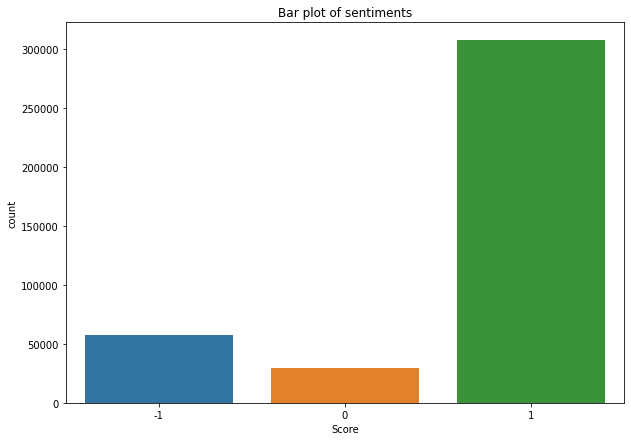

In [ ]:
plt.figure(figsize = (10,7))
sns.countplot(final_df['Score'])
plt.title("Bar plot of sentiments")

In [ ]:
def decontract(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

In [ ]:
#set of custom stop words
stop_words= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
def preprocess_text(review):
    review = re.sub(r"http\S+", "", review)             # removing website links
    review = BeautifulSoup(review, 'lxml').get_text()   # removing html tags
    review = decontract(review)                         # decontracting
    review = re.sub("\S*\d\S*", "", review).strip()     # removing the words with numeric digits
    review = re.sub('[^A-Za-z]+', ' ', review)          # removing non-word characters
    review = review.lower()                             # converting to lower case
    review = [word for word in review.split(" ") if not word in stop_words] # removing stop words
    review = [lemmatizer.lemmatize(token, "v") for token in review] #Lemmatization
    review = " ".join(review)
    review.strip()
    return review
final_df['Text'] = final_df['Text'].apply(lambda x: preprocess_text(x))

In [ ]:
final_df

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,1,1108425600,"Nice cadence, catchy rhymes",junei saw charm groupof roses beginto droopi p...
150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,fun way children learn months year learn poems...
150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version",grow read sendak book watch really rosie movie...
150505,0006641040,A2PTSM496CF40Z,"Jason A. Teeple ""Nobody made a greater mistak...",1,1,1,1210809600,A classic,get movie sound track sing along carol king gr...
150504,0006641040,AQEYF1AXARWJZ,"Les Sinclair ""book maven""",1,1,1,1212278400,Chicken Soup with Rice,entertain rhyme story cleaver catchy illustrat...
...,...,...,...,...,...,...,...,...,...
193172,B009RSR8HO,A3JJTHP8T7A8LY,"Joanne Eklund ""Joanne""",0,0,1,1350432000,Zero,fts zero best sweetener ever try no aftertaste...
188389,B009SF0TN6,A1L0GWGRK4BYPT,Bety Robinson,0,0,1,1350518400,Amazing!! Great sauce for everything!,try sauce believe start little sweet honey tas...
221795,B009SR4OQ2,A32A6X5KCP7ARG,sicamar,1,1,1,1350604800,Awesome Taste,buy hazelnut paste nocciola spread local shop ...


In [ ]:
Y = pd.get_dummies(final_df['Score']).values

In [ ]:
from sklearn.model_selection import train_test_split
rev=final_df["Text"]
#Y = pd.get_dummies(final_df['sentiment']).values
#Y = final_df["Score"]
x_train, x_test, y_train, y_test = train_test_split(rev,Y,test_size=0.2,random_state=0,stratify=Y)

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
# Number of words to consider as features
max_features = 10000

maxlen = 20 #Maximum sequence length
batch_size = 32 #the number of rows of input for each step

#Tokenizing
tokenizer=Tokenizer(max_features,oov_token="<?>")
tokenizer.fit_on_texts(x_train)
X_train=tokenizer.texts_to_sequences(x_train)
X_test=tokenizer.texts_to_sequences(x_test) #Those 4 rows transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from 1 - max_features

print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')


print('Pad sequences (samples x text length)')
X_train = pad_sequences(X_train, maxlen=maxlen) #make sure that the length of every array reaches maxlen by filling zeros in front of all arrays. Not all text contents have the maxlen we set in original dataset.
X_test = pad_sequences(X_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

315146 train sequences
78787 test sequences
Pad sequences (samples x text length)
X_train shape: (315146, 20)
X_test shape: (78787, 20)


In [ ]:
x_train

Id
435519    damage can well eight can dent box perfectly p...
448170    like kashi bar like right blend chocolate oats...
267968    fall regatta feed people chicken rib prepare i...
95566     tasty light smallish side sure mean snack not ...
324811    chocolate chip real thing organic not somethin...
                                ...                        
416939    great snack go unlike fruit bar bite fiber mak...
138884    starbucks blonde coffees comparable dunkin don...
236891    use clump clay litter two years older cat tire...
314283    live ne pa could not find fiesta ranch dip pac...
411461    regular joe not know much honey think might he...
Name: Text, Length: 315146, dtype: object

In [ ]:
from keras.layers import Dense,Conv1D,MaxPooling1D
model = Sequential()
#model.add(layers.Embedding(max_features, embedding_dim, input_length=maxlen))
model.add(Embedding(max_features,32, input_length=maxlen))
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(layers.LSTM(100,dropout=0.2,recurrent_dropout=0.2,kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5)) 
model.add(Dense(3,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 32)            320000    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 3)                 303       
                                                                 
Total params: 373,503
Trainable params: 373,503
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics='acc') #mape: Mean Absolute Percentage Error
history = model.fit(X_train, y_train,
                    epochs=10,
                    steps_per_epoch = 128,
                    batch_size=batch_size,
                   validation_data=(X_test,y_test))

keras.backend.clear_session()
del model

Epoch 1/10
128/128 [==============================] - 22s 152ms/step - loss: 0.8571 - acc: 0.7803 - val_loss: 0.6135 - val_acc: 0.7808
Epoch 2/10
128/128 [==============================] - 19s 149ms/step - loss: 0.5921 - acc: 0.7893 - val_loss: 0.5581 - val_acc: 0.8001
Epoch 3/10
128/128 [==============================] - 19s 149ms/step - loss: 0.5526 - acc: 0.8042 - val_loss: 0.5323 - val_acc: 0.8113
Epoch 4/10
128/128 [==============================] - 19s 150ms/step - loss: 0.5186 - acc: 0.8157 - val_loss: 0.5238 - val_acc: 0.8106
Epoch 5/10
128/128 [==============================] - 19s 148ms/step - loss: 0.5068 - acc: 0.8247 - val_loss: 0.5154 - val_acc: 0.8096
Epoch 6/10
128/128 [==============================] - 19s 153ms/step - loss: 0.5109 - acc: 0.8254 - val_loss: 0.5024 - val_acc: 0.8208
Epoch 7/10
128/128 [==============================] - 19s 148ms/step - loss: 0.5134 - acc: 0.8188 - val_loss: 0.4985 - val_acc: 0.8200
Epoch 8/10
128/128 [==============================] - 1

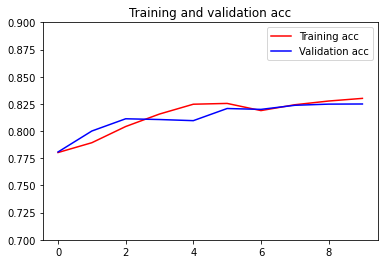

In [ ]:
import matplotlib.pyplot as plt

mape = history.history['acc']
val_mape = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, mape, 'r', label='Training acc')
plt.plot(epochs, val_mape, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()
plt.ylim(ymax=0.9,ymin=0.7)

plt.show()